In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from src.analysis import *
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm,trange
from time import sleep
import random

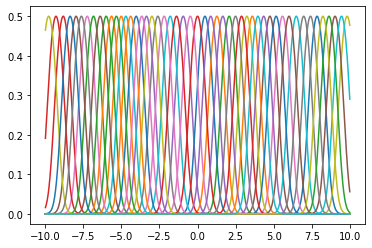

In [38]:
#Architecture parameters and distirbutions of stimuli
N = 50
K = 10
M=100
p_x = torch.distributions.uniform.Uniform(-10,10)

#Training parameters
#(Note that in this toy model we can generate as many data as we want, since the distribution is relatively simple, so the distinction between N_SAMPLES and BATCH_SIZE is not very neat)
N_EPOCHS = 1000
N_SAMPLES = 10000
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)


#Initialization of encoder and decoder 
enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2)
#Having a dataset, use K-Means to initialize centers
km = KMeans(n_clusters = N).fit(x_samples)
enc.cs = torch.nn.Parameter(torch.tensor(km.cluster_centers_).transpose(0,1).to(dtype=torch.float32))

inv_sigma2 = torch.exp(-2*enc.log_sigmas).transpose(0,1)
phi0 = torch.cat((enc.cs.transpose(0,1)*inv_sigma2,-0.5*inv_sigma2),dim=1)
#dec = GaussianDecoder(phi0)
dec = MLPDecoder(N,M)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach());


In [3]:
def VAMP_train(encoder,decoder,opt,data_loader,epochs,x_fine,x_k = None,Beta=1.):
        train_hist = {'ELBO':[],'D':[],'R':[],'MSE':[]}
        tepoch=  tqdm(range(epochs), unit="epoch",position=1,leave=True)
        tbatch = tqdm(data_loader, unit="batch",position=0,leave=True)
        for epoch in tepoch:
                train_hist['ELBO'].append(0)
                train_hist['D'].append(0)
                train_hist['R'].append(0)
                train_hist['MSE'].append(0)
                tepoch.set_description(f"Epoch {epoch}")
                tbatch.refresh()
                tbatch.reset()
                tepoch.update()
                for x_ in tbatch:
                        dloss = distortion_gaussian(x_,encoder,decoder) 
                        rloss =  rate_vampBernoulli(x_,encoder,x_k)
                        #print(x_k[0])
                        loss = dloss + Beta*rloss
                        train_hist['ELBO'][-1] += loss.item()
                        train_hist['D'][-1] += dloss.item()
                        train_hist['R'][-1] += rloss.item()
                        tepoch.set_postfix(loss=loss.item())
                if not torch.isnan(loss):
                        opt.zero_grad()
                        loss.backward()
                        opt.step()
                train_hist['MSE'][-1] += MSE_montecarlo(x_fine,encoder,decoder).item()
                train_hist['ELBO'][-1] /= tbatch.total
                train_hist['D'][-1] /= tbatch.total
                train_hist['R'][-1] /= tbatch.total
                if torch.isnan(loss):
                        break;
                else:
                        continue
                break
        draw_hist(train_hist)
        return encoder,decoder,train_hist       




  0%|          | 0/1000 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

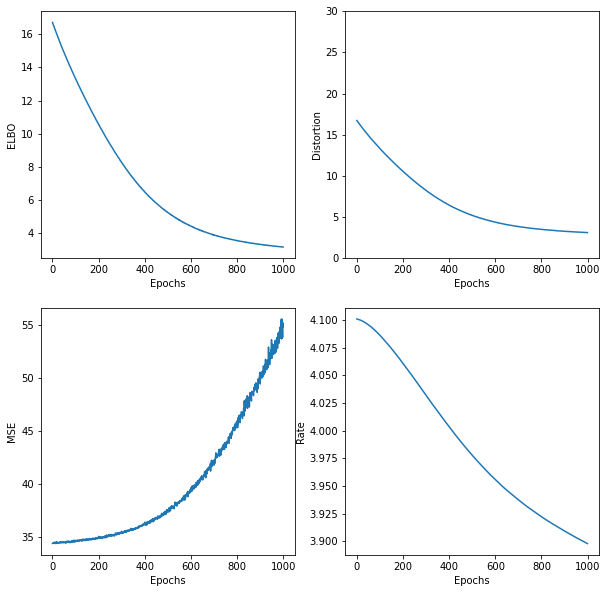

In [4]:
encoder = BernoulliEncoder(N,x_min-0.2,x_max+0.2)
#Having a dataset, use K-Means to initialize centers
km = KMeans(n_clusters = N).fit(x_samples)
encoder.cs = torch.nn.Parameter(torch.tensor(km.cluster_centers_).transpose(0,1).to(dtype=torch.float32))
decoder = MLPDecoder(N,M)
x_k = torch.arange(x_min,x_max,(x_max-x_min)/K)[:,None]
#x_k = p_x.sample()
x_k.requires_grad = True
params = list(encoder.parameters())[0:2] + list(decoder.parameters()) + list([x_k])
optimizer = torch.optim.Adam(params,1e-4)
encoder,decoder,train_hist = VAMP_train(encoder,decoder,optimizer,x_data,N_EPOCHS,x_fine,x_k,Beta=0)

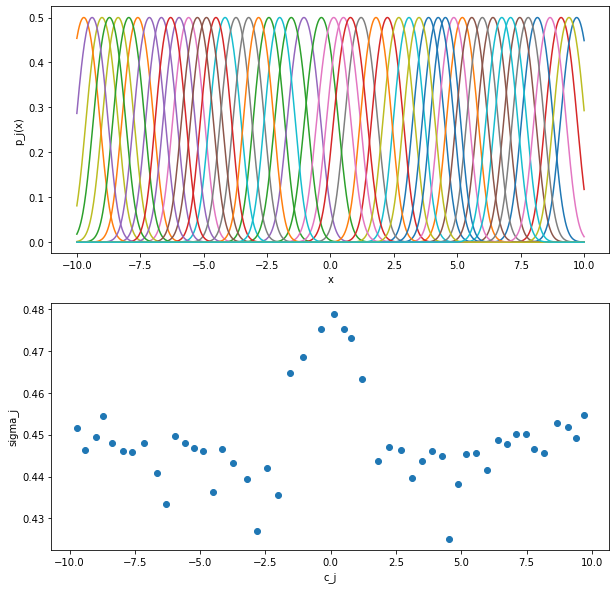

In [15]:
encoder_properties(enc,x_fine)

In [39]:
x_k = torch.arange(x_min,x_max,(x_max-x_min)/K)[:,None]
#x_k = p_x.sample()
x_k.requires_grad = True
params =  list(dec.parameters()) #+ list([x_k])
opt = torch.optim.Adam(params,1e-4)
lossVec = []
tepoch=  tqdm(range(N_EPOCHS), unit="epoch",position=1,leave=True)
tbatch = tqdm(x_data, unit="batch",position=0,leave=True)
for epoch in tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        tbatch.refresh()
        tbatch.reset()
        tepoch.update()
        for x_ in tbatch:
                dloss = distortion_gaussian(x_,enc,dec) 
                rloss =  rate_vampBernoulli(x_,enc,x_k)
                #print(x_k[0])
                loss = dloss + 0*rloss
                lossVec.append(loss.item())
                tepoch.set_postfix(loss=loss.item())
        if not torch.isnan(loss):
                opt.zero_grad()
                loss.backward()
                opt.step()
        if torch.isnan(loss):
                break;
        else:
                continue
        break

  0%|          | 0/1000 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

tensor(34.7090)


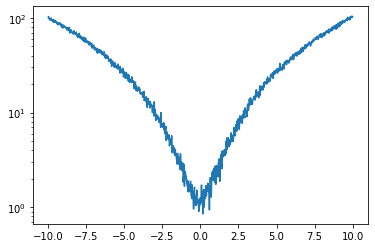

In [36]:
r = enc.sample(x_fine,10)
x_dec = dec.sample(r,10)
mseVec = ((x_dec - x_fine[None,:])**2).mean(dim=(0,2))
print(mseVec.mean())
plt.plot(x_fine,mseVec.detach())
plt.yscale("log")


In [37]:
dec(r)[0]

tensor([[-0.1128, -0.0831, -0.0624,  ..., -0.0831, -0.1128, -0.1128],
        [-0.1128, -0.0369, -0.1128,  ..., -0.0624, -0.1128, -0.0369],
        [-0.0624, -0.0624, -0.1634,  ..., -0.1128, -0.1128, -0.0624],
        ...,
        [-0.0624, -0.0686, -0.0656,  ..., -0.0686, -0.0624, -0.0656],
        [-0.0207, -0.0686, -0.0624,  ..., -0.0686, -0.0656, -0.0686],
        [-0.0624, -0.0624, -0.0624,  ..., -0.0624, -0.0686, -0.0624]],
       grad_fn=<SqueezeBackward0>)

(array([9.2067e+04, 5.8510e+03, 7.1200e+02, 4.4300e+02, 2.9800e+02,
        2.5100e+02, 1.9700e+02, 1.2100e+02, 5.0000e+01, 1.0000e+01]),
 array([1.4305115e-06, 1.2701408e+00, 2.5402801e+00, 3.8104196e+00,
        5.0805588e+00, 6.3506985e+00, 7.6208377e+00, 8.8909769e+00,
        1.0161117e+01, 1.1431255e+01, 1.2701395e+01], dtype=float32),
 <BarContainer object of 10 artists>)

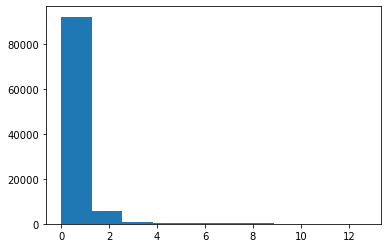

In [62]:
errors = np.abs(torch.flatten((x_dec - x_fine[None,:])))
plt.hist(errors.numpy())

(array([9.4241e+04, 3.7010e+03, 6.7700e+02, 4.6500e+02, 3.3400e+02,
        2.5900e+02, 1.8300e+02, 1.0600e+02, 2.7000e+01, 7.0000e+00]),
 array([2.8610229e-06, 1.4366692e+00, 2.8733356e+00, 4.3100019e+00,
        5.7466683e+00, 7.1833348e+00, 8.6200008e+00, 1.0056667e+01,
        1.1493334e+01, 1.2930000e+01, 1.4366667e+01], dtype=float32),
 <BarContainer object of 10 artists>)

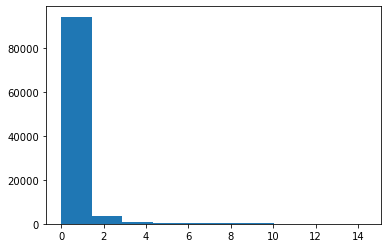

In [ ]:
errors = np.abs(torch.flatten((x_dec - x_fine[None,:])))
plt.hist(errors.numpy())

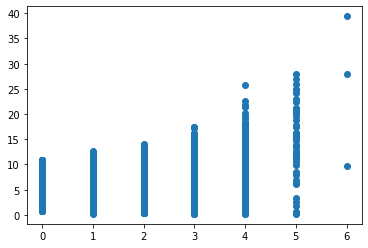

In [16]:
plt.scatter(torch.flatten(r.sum(dim=2)),torch.flatten(torch.abs(x_dec - x_fine[None,:]).mean(dim=0)))

In [24]:
#Prior approximation
r = enc.sample(x_fine,10)
mu_dec,sigma2_dec = dec(r)
for x_ in x_fine:   
    q_x_r = torch.distributions.normal.Normal(mu_dec,torch.sqrt(sigma2_dec))


tensor([[  0.2907,  -0.8870,  -2.2287,  ...,   0.2907,  -1.7924,  -0.3502],
        [-10.7253,  -1.0952, -10.7253,  ...,   0.3814, -10.7253,   0.1998],
        [ -0.6960,  -3.2245,   0.3101,  ...,  -0.6960,   0.4615,  -3.2245],
        ...,
        [  0.6323,   0.0790,   0.2567,  ...,   0.0790,   0.6323,   0.2539],
        [ -0.0556,  -1.1197,   0.0408,  ...,  -1.3578,   0.0293,   0.5764],
        [ -1.0979,  -2.1237,  -1.0524,  ...,  -9.8426,  -1.0524,  -9.8426]],
       grad_fn=<SubBackward0>)